In [202]:
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import cm
from matplotlib.colors import to_hex
from scipy.stats import dirichlet, beta, norm
from math import isclose

In [3]:
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels

In [210]:
_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 \
              for i in range(3)]

def xy2bc(xy, tol=1.e-16):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

            
def draw_pdf(alpha, trimesh):
    pvals = [dirichlet.pdf(x=xy2bc(xy), alpha=alpha) for xy in zip(trimesh.x, trimesh.y)]
    return pvals

def plot_simplex(alpha, nlevels=200, subdiv=8):
    n = len(alpha)
    refiner = tri.UniformTriRefiner(triangle)
    fig, axs = plt.subplots(2, 3, figsize=(12,8))
    xlabel = string.ascii_lowercase[:n+1]
    for i in range(2):
        for j in range(3):
            if  (i==0 and j==0) or (i==1 and j==1): 
                trimesh = refiner.refine_triangulation(subdiv=int(subdiv/2))
                pvals = draw_pdf(alpha[3*i+j], trimesh)
                axs[i,j].tricontourf(trimesh, pvals, nlevels, cmap='jet') 
            elif (i==0 and j==1):
                trimesh = refiner.refine_triangulation(subdiv=0)
                pvals = draw_pdf(alpha[3*i+j], trimesh)
                jet = cm.get_cmap('jet', nlevels)
                axs[i,j].tricontourf(trimesh, pvals, colors=to_hex(jet(0.01))) 
            else:
                trimesh = refiner.refine_triangulation(subdiv=subdiv)
                pvals = draw_pdf(alpha[3*i+j], trimesh)
                axs[i,j].tricontourf(trimesh, pvals, nlevels, cmap='jet') 
            
            axs[i,j].tick_params(which='both', bottom=False, left=False,labelbottom=False, labelleft=False) 
            axs[i,j].set_frame_on(False)
            axs[i,j].set_xlabel(f"({xlabel[3*i+j]})")
            axs[i,j].set_title(rf"$\alpha$ = {alpha[3*i+j]}")
    plt.show()

In [70]:
alpha = [[0.1,0.1,0.1], [1, 1, 1], [2, 2, 2], [10, 10, 10], [1, 1, 0.5], [5, 1, 1]]

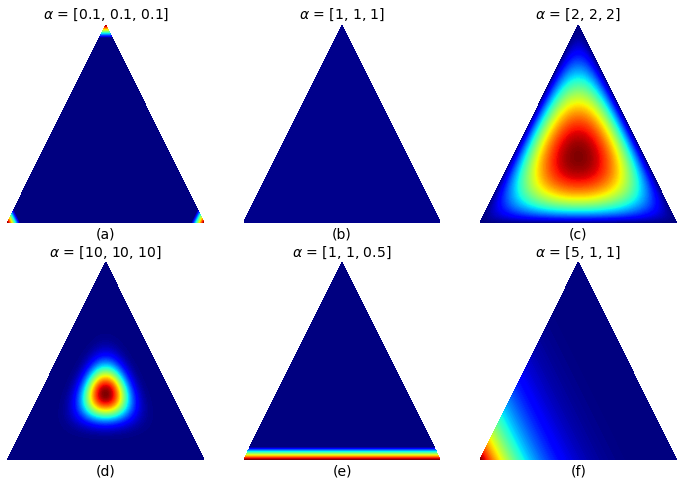

In [213]:
plot_simplex(alpha, nlevels=200, subdiv=8)

In [12]:
def plot_atoms(alpha, k):
    m = len(alpha)
    n = len(k)
    xlabel = string.ascii_lowercase[:n+1]
    fig, axs = plt.subplots(m, n, figsize=(12,12))
    plt.subplots_adjust(hspace=0.35, wspace=0.3)
    for i in range(m):
        for j in range(n):
            samples = dirichlet.rvs(alpha[i]*np.ones(k[j]), random_state=0).flatten() 
            axs[i,j].bar(range(1, k[j]+1), samples, width=0.7, color="darkblue")
            if (j+1)%2==0:
                axs[i,j].set_title(rf"$\alpha$ = {alpha[i]}")
                axs[i,j].set_xlabel(f"({xlabel[i]})")
            axs[i,j].spines['right'].set_visible(False)
            axs[i,j].spines['top'].set_visible(False)
    plt.show()

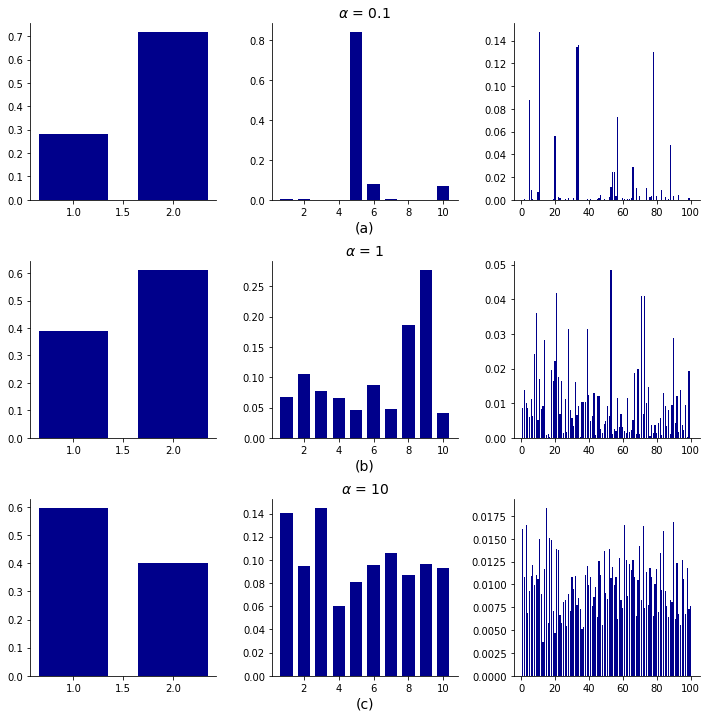

In [13]:
plot_atoms([0.1, 1, 10], [2, 10, 100])

In [34]:
def stick_breaking(alpha, seed=0):
    np.random.seed(seed)
    b = []
    pi = []
    while not isclose(sum(pi), 1, rel_tol=1e-8):
        # b_k~beta(1,alpha)
        b.append(beta.rvs(1, alpha))
        # pi_k=b_k*\prod_{j=1}^{k-1}(1-b_j)
        rest = (1-np.array(b[:-1])).prod()
        pi.append(b[-1]*rest)
    return np.array(pi)

In [19]:
def plot_sbp(alpha, pi):
    n = len(pi)
    xlabel = ["(a)", "(b)", "(c)"]
    fig, axs = plt.subplots(1, n, figsize=(12,4))   
    for i in range(n):
        samples = pi[i]
        k = len(samples)
        axs[i].bar(range(1, k+1), samples, width=0.7, color="darkblue")
        axs[i].set_title(rf"$\alpha$ = {alpha[i]}")
        axs[i].set_xlabel(xlabel[i])
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
    plt.show()

In [35]:
pi1 = stick_breaking(0.1, 9)
pi2 = stick_breaking(0.6, 100)
pi3 = stick_breaking(6, 0)
pi = [pi1, pi2, pi3]
alpha = [0.1, 0.6, 6]

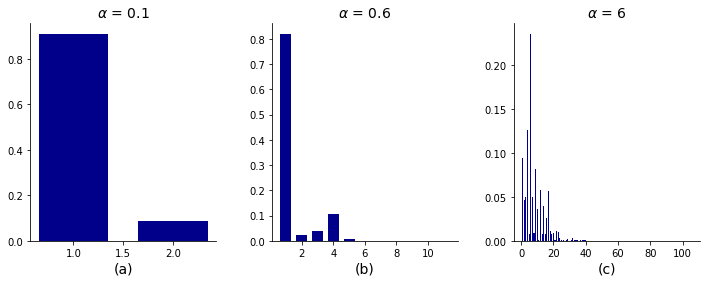

In [36]:
plot_sbp(alpha, pi)

In [80]:
def dirichlet_process(alpha, mu=0, sigma=1, seed=0):
    # atoms sizes
    pi = stick_breaking(alpha, seed=seed)
    # gaussian base measure
    np.random.seed(seed)
    phi = np.array([norm.rvs(mu,sigma) for pi_k in pi]) 
    return pi, phi

In [81]:
def plot_dp(pi, phi, alpha):
    n = len(pi)
    xlabel = ["(a)", "(b)", "(c)"]
    fig, axs = plt.subplots(1, n, figsize=(12,4))
    for i in range(n):
        x_axis = np.arange(-15, 15, 0.001)
        axs[i].plot(x_axis, norm.pdf(x_axis, 0, 1))
        axs[i].vlines(x=phi[i], ymin=0, ymax=pi[i], color='black', linewidth=1.3)
        axs[i].scatter(x=phi[i], y=pi[i], s=75, color='darkblue')
        axs[i].set_title(rf"$\alpha$ = {alpha[i]}")
        axs[i].set_xlabel(xlabel[i])
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].set_xlim(-3,3)
        axs[i].set_ylim(0,1)
    plt.show()

In [76]:
pi1, phi1 = dirichlet_process(alpha=0.1, seed=9)
pi2, phi2 = dirichlet_process(alpha=0.6, seed=100)
pi3, phi3 = dirichlet_process(alpha=6, seed=0)
pi = [pi1, pi2, pi3]
phi = [phi1, phi2, phi3]
alpha = [0.1, 0.6, 6]

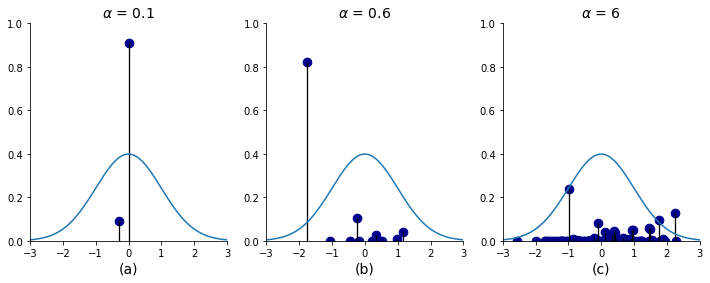

In [82]:
plot_dp(pi, phi, alpha)